Notebook for computing stable steady state GNE
for the nine species gut microbiome model. 
Also includes code for generating Figure 4 in the paper.

In [1]:
import numpy as np
import scipy.io as sio
import scipy.sparse as sparse
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pickle
import main
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2



Note: this is the final notebook for computing steady states for the nine species model and checking their stability.

In [2]:
directory = '../ModelFiles/'

S = sio.loadmat(directory + 'S.mat')['S']
I = sio.loadmat(directory + 'I.mat')['I'][0][0]
J = sio.loadmat(directory + 'J.mat')['J'][0][0]
reaction_lb = sio.loadmat(directory + 'lb.mat')['lb']
reaction_ub = sio.loadmat(directory + 'ub.mat')['ub']
lumen_reactions_idx = sio.loadmat(directory + 'lumen_reactions_idx.mat')['lumen_uptake_reactions_idx'] - 1
lumen_metabolites_idx = sio.loadmat(directory + 'lumen_metabolites_idx.mat')['lumen_metabolites_idx'] - 1
lumen_reaction_names = sio.loadmat(directory + 'lumen_reactions.mat')['lumen_uptake_reactions']
lumen_reaction_names = np.array([lumen_reaction_names[i][0] for i in range(len(lumen_reaction_names))])
Jl = len(lumen_reactions_idx)
spAbbr = ['Bt', 'Fp', 'Kp', 'St', 'Ba', 'Ec', 'Ef', 'Er', 'Lc']
death_rate = 0.06
max_iters = 5
delta_max = 1
delta_min = 1e-3
C = 5e1
B = 3
sigmoid = lambda x : 1 / (1 + np.exp(-x))
k = np.linspace(0, max_iters, max_iters)
delta_vals = delta_min + (delta_max - delta_min) * sigmoid(k/C - B)


In [5]:
species_params = []
for i in range(9):
    species_params.append({'name':spAbbr[i]})
    species_params[i]['reactions_idx'] = sio.loadmat(directory + spAbbr[i] + '_reactions_idx.mat')[spAbbr[i] + '_reactions_idx'] - 1
    species_params[i]['reaction_names'] = sio.loadmat(directory + spAbbr[i] + '_reactions.mat')[spAbbr[i] + '_reactions']
    species_params[i]['metabolites_idx'] = sio.loadmat(directory + spAbbr[i] + '_metabolites_idx.mat')[spAbbr[i] + '_metabolites_idx'] - 1
    species_params[i]['biomass_idx'] = sio.loadmat(directory + spAbbr[i] + '_biomass_idx.mat')[spAbbr[i] + '_biomass_idx'] - 1
    species_params[i]['I'] = len(species_params[i]['metabolites_idx'])
    species_params[i]['J'] = len(species_params[i]['reactions_idx'])
    species_params[i]['e'] = sparse.identity(species_params[i]['J'] + Jl).tocsr()[:, species_params[i]['biomass_idx'].flatten()]
    

In [4]:
# Create many samples of community composition near
# actual data for the nine species model.
num_starting_points = 100
bm_vals_target = np.array([0.45, 0.3, 0.1, 0.05, 0.02, 0.02, 0.02, 0.02, 0.02])
bm_vals_init = np.maximum(bm_vals_target[:, None] + np.random.uniform(-0.05, 0.05, (9, num_starting_points)), 0.001)
bm_vals_init = np.divide(bm_vals_init, np.sum(bm_vals_init, axis=0)[None,:])
steady_states = []
for i in range(num_starting_points):
    print('Biomass sample ', i)
    output = main.initial_guess(bm_vals_init[:,i], species_params, S, Jl,
                                lumen_reactions_idx, death_rate, reaction_lb, reaction_ub)
    status = output[0]
    x_vals_init = output[1:]
    if status != 'optimal':
        pass
    num_iters, x_vals_new, bm_vals_new = main.compute_steady_state(bm_vals_init[:,i], x_vals_init, max_iters,
                                                                  1e-6, 1e-6, delta_vals, species_params,
                                                                  S, Jl, lumen_reactions_idx,
                                                                  reaction_lb, reaction_ub, death_rate)
    if num_iters < max_iters:
        x_vals_new = main.initial_guess(bm_vals_new, species_params, S, Jl,
                                        lumen_reactions_idx, death_rate, reaction_lb, reaction_ub)
        if x_vals_new[0] != 'optimal':
            pass
        steady_states.append((bm_vals_new, x_vals_new[1:]))
    print('\n')
    

Biomass sample  0
Set parameter Username
Academic license - for non-commercial use only - expires 2023-05-15
Iteration  0


In [8]:
pickle.dump(steady_states, open("steady_states_nine_species.p", "wb"))


In [4]:
steady_states = pickle.load(open("steady_states_nine_species.p", "rb"))


In [5]:
stable_steady_states = []
unstable_steady_states = []
for i in range(len(steady_states)):
    print('Checking stability of steady state ', i)
    bm_vals, x_vals = steady_states[i]
    try:
        pert_size = 1e-9
        feas_tol = 1e-2
        stable, max_eig = main.stability(bm_vals, x_vals, pert_size, 
                                        species_params, S, Jl, reaction_lb,
                                        reaction_ub, lumen_reactions_idx,
                                        lumen_metabolites_idx, feas_tol)
    except:
        continue
    
    if stable:
        stable_steady_states.append((bm_vals, x_vals, max_eig))
    else:
        unstable_steady_states.append((bm_vals, x_vals, max_eig))


Checking stability of steady state  0
Starting stability function
Checking stability of steady state  1
Starting stability function
Checking stability of steady state  2
Starting stability function
Checking stability of steady state  3
Starting stability function
Checking stability of steady state  4
Starting stability function
Checking stability of steady state  5
Starting stability function
Checking stability of steady state  6
Starting stability function
Checking stability of steady state  7
Starting stability function
Checking stability of steady state  8
Starting stability function
First block of constructing A
Second block of constructing A


In [6]:
pickle.dump(unstable_steady_states, open("unstable_steady_states_nine_species.p", "wb"))
pickle.dump(stable_steady_states, open("stable_steady_states_nine_species.p", "wb"))


In [4]:
unstable_ss = pickle.load(open('unstable_steady_states_nine_species.p', 'rb'))
stable_ss = pickle.load(open('stable_steady_states_nine_species.p', 'rb'))


In [7]:
print(len(unstable_ss))
print(len(stable_ss))


17
2


In [5]:
stable_ss1_bm = stable_ss[0][0]
stable_ss2_bm = stable_ss[1][0]

stable_ss1_bm_phyla = [stable_ss1_bm[0],
                      stable_ss1_bm[7]+stable_ss1_bm[1]+stable_ss1_bm[6]+stable_ss1_bm[8]+stable_ss1_bm[3],
                      stable_ss1_bm[4],
                      stable_ss1_bm[5]+stable_ss1_bm[2],
                      stable_ss1_bm[7]+stable_ss1_bm[1],
                      stable_ss1_bm[6]+stable_ss1_bm[8]+stable_ss1_bm[3]]

stable_ss2_bm_phyla = [stable_ss2_bm[0],
                      stable_ss2_bm[7]+stable_ss2_bm[1]+stable_ss2_bm[6]+stable_ss2_bm[8]+stable_ss2_bm[3],
                      stable_ss2_bm[4],
                      stable_ss2_bm[5]+stable_ss2_bm[2],
                      stable_ss2_bm[7]+stable_ss2_bm[1],
                      stable_ss2_bm[6]+stable_ss2_bm[8]+stable_ss2_bm[3]]


In [6]:
steadycom_bm = sio.loadmat('biomasses.mat')['biomass']
steadycom_bm_phyla = [steadycom_bm[0][0],
                    steadycom_bm[7][0]+steadycom_bm[1][0]+steadycom_bm[6][0]+steadycom_bm[8][0]+steadycom_bm[3][0],
                    steadycom_bm[4][0],
                    steadycom_bm[5][0]+steadycom_bm[2][0],
                    steadycom_bm[7][0]+steadycom_bm[1][0],
                    steadycom_bm[6][0]+steadycom_bm[8][0]+steadycom_bm[3][0]]
                    

In [32]:
steadycom_bm[0]

array([0.00078379])

In [7]:
steadycom_bm_phyla_paper_approx = [0.45, 0.5, 0.02, 0.03, 0.40, 0.1]

In [8]:
experiment1_bm_phyla_approx = [0.675, 0.29, 0.03, 0.005, 0.285, 0.005]
experiment2_bm_phyla_approx = [0.35, 0.62, 0.02, 0.01, 0.6, 0.02]


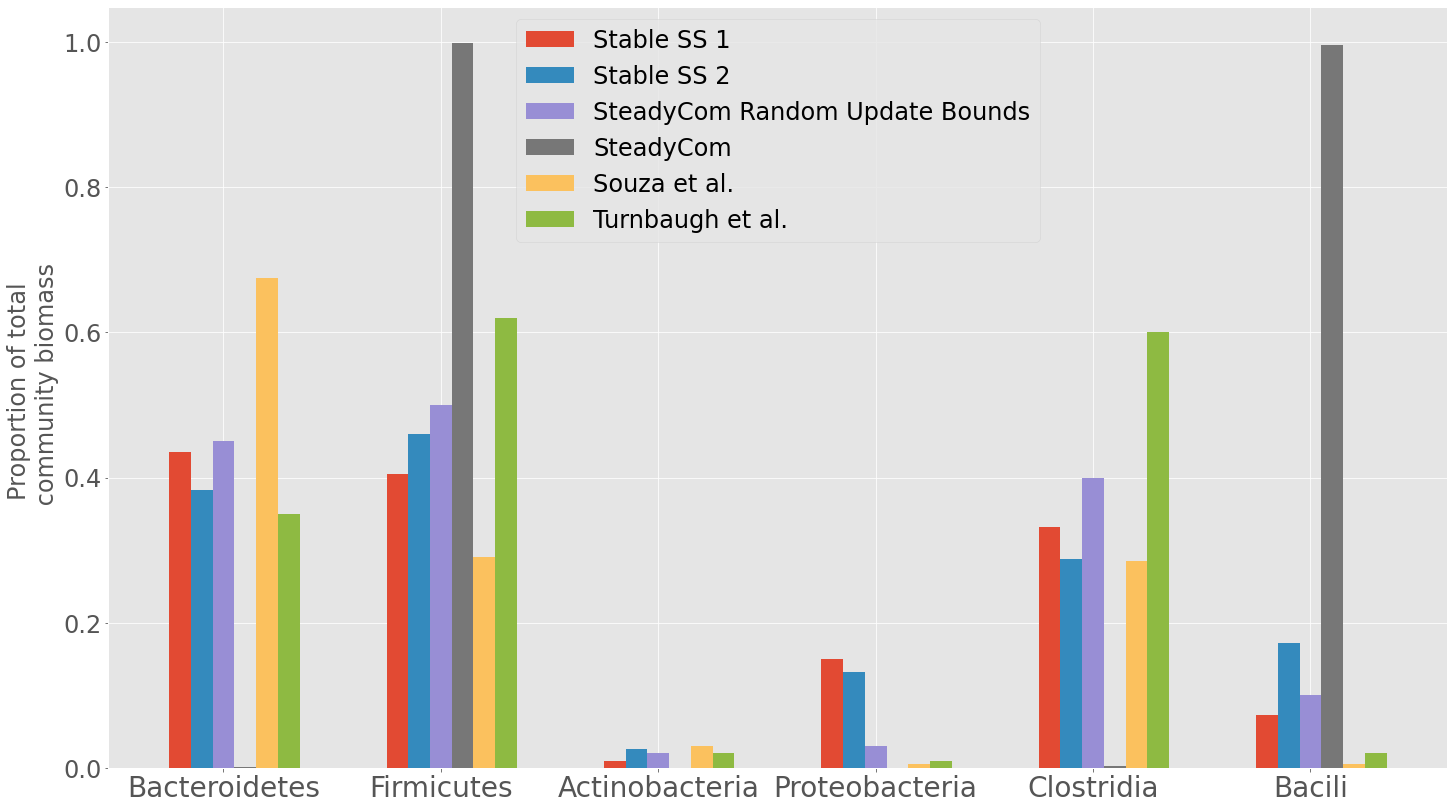

In [17]:
phyla = ['Bacteroidetes', 'Firmicutes', 'Actinobacteria', 'Proteobacteria',
        'Clostridia', 'Bacili']
barWidth = 0.2
fig = plt.subplots(figsize = (24, 14))

br1 = 2*np.arange(6)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

plt.bar(br1, stable_ss1_bm_phyla, width = barWidth, 
        label = 'Stable SS 1')
plt.bar(br2, stable_ss2_bm_phyla, width = barWidth,
        label = 'Stable SS 2')
plt.bar(br3, steadycom_bm_phyla_paper_approx, width = barWidth,
        label = 'SteadyCom Random Update Bounds')
plt.bar(br4, steadycom_bm_phyla, width = barWidth,
        label = 'SteadyCom')
plt.bar(br5, experiment1_bm_phyla_approx,
        width = barWidth, label = 'Souza et al.')
plt.bar(br6, experiment2_bm_phyla_approx,
        width = barWidth, label = 'Turnbaugh et al.')

plt.ylabel('Proportion of total \n community biomass', fontsize = 24)
plt.xticks([r + 2*barWidth for r in 2*np.arange(6)], phyla, fontsize = 28)
plt.yticks(fontsize = 24)

plt.legend(loc = 'best', fontsize = 24)
plt.savefig('nine_species_comparison.png')
plt.show()
